# Dataset Preprocessing: 

To begin with we will be preprocesssing the data as a first step to our GNN based solution to the TrackML problem. Most of the preprocessing done here is inspired by the [ExaTrkX Project](https://hsf-reco-and-software-triggers.github.io/Tracking-ML-Exa.TrkX/) [1].

[1]: Ju, Xiangyang, et al. "Performance of a geometric deep learning pipeline for HL-LHC particle tracking." The European Physical Journal C 81 (2021): 1-14.

In [29]:
# import libraries : 
import os 
import random 
import pickle
import numpy as np 
import pandas as pd 

# set random seed : 
np.random.seed( 41 )
random.seed( 41 )

import torch 
from torch import Tensor 

In [30]:
def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        return torch.device('mps')
    else:
        return torch.device('cpu')
    
    
device = get_device()
print(f"Using device: {device}")

Using device: mps


#### (1) The detector data
Read and format the ditector data once and for all, since it is of universal nature and will be required for preprocessing of each indivisual event later. 

We use memoization to store the `thickness`, `pitch` and `rotation` matrix for each of the dectector modules. This optomizes the problem. 

In [31]:
# the path to the detector data : 
detector_path = '../data/detectors.csv'

# read the csv file : 
detector_df = pd.read_csv( detector_path ) 
detector_df

,volume_id,layer_id,module_id,cx,cy,cz,rot_xu,rot_xv,rot_xw,rot_yu,...,rot_yw,rot_zu,rot_zv,rot_zw,module_t,module_minhu,module_maxhu,module_hv,pitch_u,pitch_v
0,7,2,1,-65.7965,-5.17830,-1502.5,0.078459,-0.996917,0.0,-0.996917,...,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625
1,7,2,2,-139.8510,-6.46568,-1502.0,0.046184,-0.998933,0.0,-0.998933,...,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625
2,7,2,3,-138.6570,-19.34190,-1498.0,0.138156,-0.990410,0.0,-0.990410,...,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625
3,7,2,4,-64.1764,-15.40740,-1498.0,0.233445,-0.972370,0.0,-0.972370,...,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625
4,7,2,5,-136.2810,-32.05310,-1502.0,0.228951,-0.973438,0.0,-0.973438,...,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18723,18,12,94,-895.8950,291.09400,2952.5,0.309017,-0.951057,0.0,0.951057,...,0.0,0,0,1,0.35,66.0,72.0,78,0.12,10.40000
18724,18,12,95,-812.0900,161.53500,2947.5,0.195090,-0.980785,0.0,0.980785,...,0.0,0,0,1,0.35,54.0,64.2,78,0.12,10.40000
18725,18,12,96,-925.3150,176.51300,2955.5,0.187381,-0.982287,0.0,0.982287,...,0.0,0,0,1,0.35,66.0,72.0,78,0.12,10.40000
18726,18,12,97,-826.2270,54.15380,2944.5,0.065403,-0.997859,0.0,0.997859,...,0.0,0,0,1,0.35,54.0,64.2,78,0.12,10.40000


In [32]:
def process_detector_data(detector_path:str)->dict: 
    '''
    param detector_path: path like string pointing to
        the path of the detector csv file. 
    returns detector: a dictionary object containgin the rotational matrics 
        pitch and thickness for all each volume and layer id. 
    '''
    
    # read the dectector data frame 
    detector_df = pd.read_csv( detector_path )
    
    # first get max vallues of the volume_id , layer_id and module_id 
    vid_max , lid_max , mid_max = (
        detector_df.volume_id.max() + 1 , 
        detector_df.layer_id.max()  + 1 , 
        detector_df.module_id.max() + 1 
    )
    
    # initialize the result dictionary 
    detector = {} 
    
    # initialize the arrays : 
    # for thickness, pitch_u and pitch_v of the module
    detector['thickness'] ,detector['pitch_u'] , detector['pitch_v'] = (np.zeros(shape=(vid_max,lid_max,mid_max)) for _ in range(3))
    # rotation matrices from local to grobal coordinates : 
    detector['rotation'] = np.zeros(shape=(vid_max,lid_max,mid_max,3,3))
    # also store the total number of unnique modules : 
    detector['module_count'] = detector_df.shape[0]
    
    # memoization : 
    for _ , r in detector_df.iterrows() : 
        # print( r[['volume_id','layer_id','module_id']].to_numpy(dtype = int) )  
        v , l , m = r[['volume_id','layer_id','module_id']].to_numpy(dtype = int)
        
        detector['thickness'][v,l,m] = 2*r.module_t 
        detector['pitch_u'][v,l,m] = r.pitch_u  
        detector['pitch_v'][v,l,m] = r.pitch_v 
        detector['rotation'][v,l,m] = np.array([
            [r.rot_xu,r.rot_xv,r.rot_xw], 
            [r.rot_yu,r.rot_yv,r.rot_yw], 
            [r.rot_zu,r.rot_zv,r.rot_zw]
        ])
        
    del detector_df 
        
    return detector

In [33]:
for i , r in detector_df.iterrows() : 
    if i == 1000: 
        print( r.pitch_v )

0.05625


save this as .pickel object in the data folder for future use

create a function to load the detector pickle dataset if it has been preprocessed, else first create the pickel dataset and then load the preprocesed detector dataset 

In [34]:
def load_detector_data(detector_path:str)->dict: 
    detector_pickle_path = os.path.splitext(detector_path)[0] + '.pickle'
    try: 
        with open(detector_pickle_path,"rb") as f:
            detector = pickle.load(f)
    except: 
        print('Preprocessing Detector Data ... ' )
        print('Note this is only a one time process')
        detector = process_detector_data(detector_path) 
        with open( detector_pickle_path , 'wb' ) as f : 
            pickle.dump(detector , f ) 
        print(f'Detector Preprocessing Complete.\nThe preprocessed dictionaty is saved at {detector_pickle_path}.')
    return detector 

In [35]:
detector = load_detector_data(detector_path)
detector.keys()

dict_keys(['thickness', 'pitch_u', 'pitch_v', 'rotation', 'module_count'])

In [36]:
# loading it again will not require the preprocessing step: 
detector = load_detector_data(detector_path)

In [37]:
# check this for a example module : 
idx = random.randint(0,detector['module_count']-1)
print( detector_df.iloc[idx])
print('-'*30)
v,l,m=detector_df.iloc[idx][['volume_id' , 'layer_id' , 'module_id']].to_numpy(int)
for key , val in detector.items(): 
    if key == 'module_count' : 
        continue
    print("{:10s}:{}".format(key,val[v,l,m])) 

volume_id         17.000000
layer_id           2.000000
module_id         58.000000
cx               814.472000
cy              -107.227000
cz             -1030.000000
rot_xu             0.277220
rot_xv             0.000000
rot_xw             0.960806
rot_yu             0.960806
rot_yv             0.000000
rot_yw            -0.277220
rot_zu             0.000000
rot_zv             1.000000
rot_zw             0.000000
module_t           0.350000
module_minhu      24.000000
module_maxhu      24.000000
module_hv         54.000000
pitch_u            0.120000
pitch_v           10.800000
Name: 12485, dtype: float64
------------------------------
thickness :0.7
pitch_u   :0.12
pitch_v   :10.8
rotation  :[[ 0.27722   0.        0.960806]
 [ 0.960806  0.       -0.27722 ]
 [ 0.        1.        0.      ]]


#### (2) Preprocess Hits and Cells dataset

In [ ]:
# path to all the csv files : 
train_path = '../data/train_100_events/'

# get a list of all event ids: 
event_ids = [code[:-9] for code in os.listdir(train_path) if code.endswith('-hits.csv') ] 
# number of events : 
nevent = len(event_ids)
print(f'total number of events: {nevent}')

# pick a random event : 
idx = random.randint(0,nevent-1)
eventid = event_ids[idx]
print(f"chosen event : {eventid}")

total number of events: 100
chosen event : event000001037


In [39]:
# read the csv files of the hits and cells data set : 
hits = pd.read_csv(train_path+eventid+'-hits.csv')
cells = pd.read_csv(train_path+eventid+'-cells.csv')
print('Hits Dataset:')
display(hits)
print('Cells Dataset:')
display(cells)

Hits Dataset:


,hit_id,x,y,z,volume_id,layer_id,module_id
0,1,-100.5680,-13.156000,-1502.5,7,2,1
1,2,-68.3405,-6.908230,-1502.5,7,2,1
2,3,-72.9169,-6.114840,-1502.5,7,2,1
3,4,-58.7333,-1.673560,-1502.5,7,2,1
4,5,-100.0020,-1.074390,-1502.5,7,2,1
...,...,...,...,...,...,...,...
115615,115616,-979.6590,93.557900,2952.5,18,12,98
115616,115617,-948.6330,89.802400,2952.5,18,12,98
115617,115618,-992.8450,49.599100,2952.5,18,12,98
115618,115619,-887.9730,60.195000,2952.5,18,12,98


Cells Dataset:


,hit_id,ch0,ch1,value
0,1,272,1267,0.289379
1,1,272,1266,0.040667
2,2,198,687,0.286314
3,3,175,767,0.237836
4,4,109,510,0.137764
...,...,...,...,...
640956,115618,492,12,1.000000
640957,115619,636,2,1.000000
640958,115619,635,2,1.000000
640959,115620,134,1,1.000000


##### (2a) Direct Information from Hits and Cells Dataset 

From the hits dataset we retain the spatial information of the hits in cylindricical coordinates (`r`, $ \cos \phi $ , $\sin \phi$,`z`) for each hit. Note rather than using just $\phi$ as a feature variable we use $\sin$ and $\cos$ transformations to deal with the periodic nature of angles [2]. This gives us the information about the the _global spatial information of the hit, as in where the hit occoured according to the lab frame. 
The choise of cylindrical coordinates is natural due to the geometery of the detector [3]. 

From cells dataset we insert the _total number of cells_ that are activated by a perticular hit and the total _signal value_ a hit has diposited on the detector. 

[2]: [Article Link](https://blog.dailydoseofds.com/p/cyclical-feature-engineering)

[3]: Amrouche, Sabrina, et al. The tracking machine learning challenge: accuracy phase. Springer International Publishing, 2020.

In [40]:
def Cartesian_to_Spherical(x,y,z): 
    r = np.sqrt( x*x + y*y + z*z ) 
    rxy = np.sqrt( x*x + y*y )
    theta = np.arccos(z/r)
    sphi  = y/rxy 
    cphi  = x/rxy 
    del rxy 
    return r,theta,sphi,cphi 

def Cartesian_to_Cylindrical(x,y,z): 
    rxy = np.sqrt( x*x + y*y ) 
    # sin phi 
    sinphi = y/rxy 
    cosphi = x/rxy 
    return rxy , sinphi , cosphi , z  

In [41]:
# initialize the processed event dataframe : 
processed_event = hits.loc[: , ['hit_id' ]]
# global spatial position of the hits :
(
    processed_event['r'], 
    processed_event['sphi'],
    processed_event['cphi'],
    processed_event['z']
) = Cartesian_to_Cylindrical(*hits.loc[ : , ['x' , 'y' , 'z']].to_numpy().T)
# number of cells activated 
processed_event['ncells'] = cells.groupby('hit_id').hit_id.count().values.copy() 
# total signal value deposited 
processed_event['tvalue'] = cells.groupby('hit_id').value.sum().values.copy()

processed_event 

,hit_id,r,sphi,cphi,z,ncells,tvalue
0,1,101.424864,-0.129712,-0.991552,-1502.5,2,0.330046
1,2,68.688773,-0.100573,-0.994930,-1502.5,1,0.286314
2,3,73.172847,-0.083567,-0.996502,-1502.5,1,0.237836
3,4,58.757139,-0.028483,-0.999594,-1502.5,7,0.408580
4,5,100.007771,-0.010743,-0.999942,-1502.5,1,0.287705
...,...,...,...,...,...,...,...
115615,115616,984.116272,0.095068,-0.995471,2952.5,1,1.000000
115616,115617,952.874094,0.094244,-0.995549,2952.5,1,1.000000
115617,115618,994.083128,0.049894,-0.998755,2952.5,2,2.000000
115618,115619,890.010948,0.067634,-0.997710,2952.5,2,2.000000


##### (2b) local volume of the Hit's Impact on the Detector. 

We derive the local impact physical volume of the i.e the variables _u_,_v_ and _w_ that give the spatial and volumetric information specific to the local module level data. 

In [42]:
# we write a function that gives us the local 
# spatial coordinates of the hit on that module : 
def get_local_differential_volume(processed_event:pd.DataFrame,hits:pd.DataFrame,cells:pd.DataFrame,detector:dict)->None: 
    '''
    lu , lv , lw: local diffrential direction of the hit 
        regestired on the detector. 
    '''
    # get the volume , layer and module ids for each event : 
    vid , lid , mid = hits.loc[ : , ['volume_id' , 'layer_id' , 'module_id']].values.T 
    
    # extent of channel 0 and 1 pixels (u-axis and v-axis respectively)
    foo =cells.groupby('hit_id').ch0.agg(['max', 'min']).values 
    processed_event['lu'] = (foo[:,0]-foo[:,1]+1)*detector['pitch_u'][vid,lid,mid]
    foo=cells.groupby('hit_id').ch1.agg(['max', 'min']).values 
    processed_event['lv'] = (foo[:,0]-foo[:,1]+1)*detector['pitch_v'][vid,lid,mid] 
    
    # thickness of the detector ( perpendicular to the plane of the module ): 
    processed_event['lw'] = detector['thickness'][vid,lid,mid]
    
    del foo , vid , mid , lid 
    
get_local_differential_volume(processed_event,hits,cells,detector)

In [43]:
processed_event

,hit_id,r,sphi,cphi,z,ncells,tvalue,lu,lv,lw
0,1,101.424864,-0.129712,-0.991552,-1502.5,2,0.330046,0.05,0.11250,0.3
1,2,68.688773,-0.100573,-0.994930,-1502.5,1,0.286314,0.05,0.05625,0.3
2,3,73.172847,-0.083567,-0.996502,-1502.5,1,0.237836,0.05,0.05625,0.3
3,4,58.757139,-0.028483,-0.999594,-1502.5,7,0.408580,0.20,0.22500,0.3
4,5,100.007771,-0.010743,-0.999942,-1502.5,1,0.287705,0.05,0.05625,0.3
...,...,...,...,...,...,...,...,...,...,...
115615,115616,984.116272,0.095068,-0.995471,2952.5,1,1.000000,0.12,10.40000,0.7
115616,115617,952.874094,0.094244,-0.995549,2952.5,1,1.000000,0.12,10.40000,0.7
115617,115618,994.083128,0.049894,-0.998755,2952.5,2,2.000000,0.24,10.40000,0.7
115618,115619,890.010948,0.067634,-0.997710,2952.5,2,2.000000,0.24,10.40000,0.7


##### (2c) Local and Global orentation of the hit. 

We now have the information on _where_ are he hits and to what _differential volume_ in the detector the hit is observed. Here we include featuers that will describe _HOW_ are the hits _oriented_ in the detector. 

We do this by augmenting the local and global directional angles $\theta$,$\cos \phi$,$\sin \phi$ of the diffrential direction $\mathrm{d}\vec{l} \equiv \{ lu , lv , lw \}$. 

Note since we are dealing with the differential direction, we do not care about the translation's when transforming to global coordinates, since they trivially cancel out. 

In [44]:
def get_orentations(processed_event:pd.DataFrame,hits:pd.DataFrame,cells:pd.DataFrame,detector:dict)->None: 
    '''
    gsphi , gcphi: sin and cos of the global diffential 
        spatial hit direction in spherical coordinate system. 
    gtheta, ltheta: global and local angle of the diffential 
        spatial hit direction in spherical coordinates. 
    lsphi , lcphi:  sin and cos of the global diffential 
        spatial hit direction in spherical coordinate system.  
    '''
    
    # get this volume , layer and module id:  
    vid , lid , mid  = hits.loc[:, ['volume_id' , 'layer_id' , 'module_id' ] ].values.T 
    
    # get the local spatial differential vector
    lu , lv , lw = processed_event.loc[ : , ['lu' , 'lv' , 'lw']].values.T 
    
    # for local spherical angles : 
    (
        _ , 
        processed_event['ltheta'] , 
        processed_event['lsphi'] , 
        processed_event['lcphi'] 
        
    ) = Cartesian_to_Spherical(lu,lv,lw)
    
    # get the rotations: 
    rotations = detector['rotation'][vid,lid,mid]
    
    # format the dircetions and convert them from 
    # local to  global frame of refrence: 
    lu = np.expand_dims( lu , axis = 1 )
    lv = np.expand_dims( lv , axis = 1 )
    lw = np.expand_dims( lw , axis = 1 )
    directions = np.concatenate((lu,lv,lw),axis=1)
    directions = np.expand_dims(directions,axis=2)
    
    # get the rotated vectors : 
    global_directions = np.matmul(rotations,directions).squeeze(2)
    del lu , lv , lw , directions , vid , lid , mid , rotations  
    
    # convert and store as angles in spherical coordinates : 
    (
        _ , 
        processed_event['gtheta']  , 
        processed_event['gsphi'] , 
        processed_event['gcphi']  
    ) = Cartesian_to_Spherical(*global_directions.T)
    del global_directions 
    
get_orentations(processed_event,hits,cells,detector)

In [45]:
processed_event

,hit_id,r,sphi,cphi,z,ncells,tvalue,lu,lv,lw,ltheta,lsphi,lcphi,gtheta,gsphi,gcphi
0,1,101.424864,-0.129712,-0.991552,-1502.5,2,0.330046,0.05,0.11250,0.3,0.389413,0.913812,0.406138,2.752180,-0.476583,-0.879129
1,2,68.688773,-0.100573,-0.994930,-1502.5,1,0.286314,0.05,0.05625,0.3,0.245794,0.747409,0.664364,2.895799,-0.720957,-0.692980
2,3,73.172847,-0.083567,-0.996502,-1502.5,1,0.237836,0.05,0.05625,0.3,0.245794,0.747409,0.664364,2.895799,-0.720957,-0.692980
3,4,58.757139,-0.028483,-0.999594,-1502.5,7,0.408580,0.20,0.22500,0.3,0.787128,0.747409,0.664364,2.354465,-0.720957,-0.692980
4,5,100.007771,-0.010743,-0.999942,-1502.5,1,0.287705,0.05,0.05625,0.3,0.245794,0.747409,0.664364,2.895799,-0.720957,-0.692980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115615,115616,984.116272,0.095068,-0.995471,2952.5,1,1.000000,0.12,10.40000,0.7,1.503594,0.999933,0.011538,1.503594,0.074301,-0.997236
115616,115617,952.874094,0.094244,-0.995549,2952.5,1,1.000000,0.12,10.40000,0.7,1.503594,0.999933,0.011538,1.503594,0.074301,-0.997236
115617,115618,994.083128,0.049894,-0.998755,2952.5,2,2.000000,0.24,10.40000,0.7,1.503608,0.999734,0.023071,1.503608,0.085799,-0.996312
115618,115619,890.010948,0.067634,-0.997710,2952.5,2,2.000000,0.24,10.40000,0.7,1.503608,0.999734,0.023071,1.503608,0.085799,-0.996312


In [46]:
processed_event.shape 

(115620, 16)

In [47]:
import matplotlib.pyplot as plt 

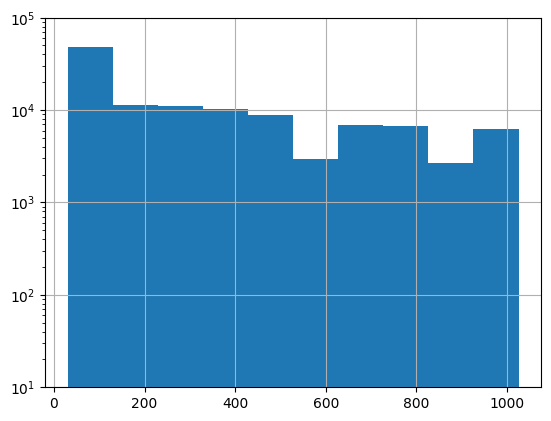

In [48]:
plt.hist( processed_event['r'] )
plt.yscale('log')
plt.grid()
plt.yticks([10**i for i in range( 1 , 6 )])
plt.show()

In [49]:
processed_event_tensor = Tensor( processed_event.iloc[: , 1: ].values )
processed_event_tensor.shape 

torch.Size([115620, 15])

#### (3) Truth Labels : 

Here we define a function which will return the particle id's accociated with each hit, from the `truth` dataset. 

We also specify a parameter `min_nhits` so as to put a threshold on the minimum stricks a particle should have on the detector to be considered for the algorithm. 

now we write a cohersive function to give us a single processsed event : 

In [50]:
# read the truth.csv file 
truth = pd.read_csv(train_path+eventid+'-truth.csv')

# add a new column nhits : the number of hits a particle leaves on the detector 
truth['nhits'] = truth.particle_id.map(truth.particle_id.value_counts())

truth 

,hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight,nhits
0,1,112591983549087744,-100.5540,-13.159300,-1502.5,-0.778871,-0.071342,-11.482700,0.000011,12
1,2,779123628888293376,-68.3417,-6.913910,-1502.5,-0.174552,0.003488,-3.823620,0.000008,12
2,3,734095604073889792,-72.9340,-6.091840,-1502.5,-1.105240,-0.115057,-22.864200,0.000015,13
3,4,567462211719532545,-58.7338,-1.672470,-1502.5,-0.431501,-0.402719,-0.902809,0.000021,5
4,5,306246217770205184,-100.0140,-1.069800,-1502.5,-0.259587,-0.029897,-4.019590,0.000007,13
...,...,...,...,...,...,...,...,...,...,...
115615,115616,0,-975.1400,93.217100,2952.5,85743.300000,-8826.280000,996278.000000,0.000000,17665
115616,115617,698063096203182080,-943.9680,89.552600,2952.5,-0.998583,-0.011995,3.222750,0.000018,10
115617,115618,418836964368711680,-996.5680,49.819800,2952.5,-1.031810,-0.062185,3.141960,0.000017,11
115618,115619,40539543471915008,-892.2090,60.490200,2952.5,-0.289945,0.124357,1.014510,0.000007,13


In [51]:
# minimum hits a particle should leave to be 
# considered 
min_nhits = 3

# filter the truth file such that if the 
# number of the hits is less then the min then the
# particle id is updated to 0. i.e. a fake hit 
truth.loc[truth.nhits < min_nhits , 'particle_id' ] = 0 

# recalculate the nhits column 
truth['nhits'] = truth.particle_id.map(truth.particle_id.value_counts())

# check : find the min hits regesterd in the detector after update : 
truth.nhits.min()

np.int64(3)

In [52]:
truth

,hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight,nhits
0,1,112591983549087744,-100.5540,-13.159300,-1502.5,-0.778871,-0.071342,-11.482700,0.000011,12
1,2,779123628888293376,-68.3417,-6.913910,-1502.5,-0.174552,0.003488,-3.823620,0.000008,12
2,3,734095604073889792,-72.9340,-6.091840,-1502.5,-1.105240,-0.115057,-22.864200,0.000015,13
3,4,567462211719532545,-58.7338,-1.672470,-1502.5,-0.431501,-0.402719,-0.902809,0.000021,5
4,5,306246217770205184,-100.0140,-1.069800,-1502.5,-0.259587,-0.029897,-4.019590,0.000007,13
...,...,...,...,...,...,...,...,...,...,...
115615,115616,0,-975.1400,93.217100,2952.5,85743.300000,-8826.280000,996278.000000,0.000000,18895
115616,115617,698063096203182080,-943.9680,89.552600,2952.5,-0.998583,-0.011995,3.222750,0.000018,10
115617,115618,418836964368711680,-996.5680,49.819800,2952.5,-1.031810,-0.062185,3.141960,0.000017,11
115618,115619,40539543471915008,-892.2090,60.490200,2952.5,-0.289945,0.124357,1.014510,0.000007,13


write a complete fiunction that returns the particle ids 

In [53]:
def process_particle_lables(train_path:str,eventid:str,min_nhits:int=3)->Tensor: 
    '''
    return the particlesids for each event from the truch.csv file 
    particles with hits less then min_hits are treated with fake hits. 
    '''
    # read the truth.csv file 
    truth = pd.read_csv(train_path+eventid+'-truth.csv')

    # add a new column nhits : the number of hits a particle leaves on the detector 
    truth['nhits'] = truth.particle_id.map(truth.particle_id.value_counts())

    # filter the truth file such that if the 
    # number of the hits is less then the min then the
    # particle id is updated to 0. i.e. a fake hit 
    truth.loc[truth.nhits < min_nhits , 'particle_id' ] = 0 
    
    return Tensor(truth.particle_id.values)

It is also handy to make a function that returns the list of unique pairs of indices that belong to the same track. As we will se later the use of this list will come about several times later in the developnment of the model.

In [54]:
x = Tensor([1,2,3,4,4,1,1,2])
mask = Tensor([1]) == x 
indices = torch.nonzero(mask , as_tuple=True)[0]
n = indices.shape[0]
row , col = torch.triu_indices(n,n, offset=1)
indices[row].tolist()

[0, 0, 5]

In [55]:
def get_track_index_pairs(particle_ids:Tensor,device)->Tensor: 
    # move to gpu if available 
    particle_ids = particle_ids.to( device )
    
    unique_id = torch.unique(
        particle_ids, return_inverse=False, sorted=False
    )
    
    row , col  =  [] , []
    for uid in unique_id:
        if( uid == 0 ): 
            continue
        mask = ( uid == particle_ids )
        indices = torch.nonzero(mask, as_tuple=True)[0]
        n = indices.size(0)
        
        if n > 1:
            # Generate all unique index pairs using broadcasting
            row_idx, col_idx = torch.triu_indices(n, n, offset=1) 
            row.extend( indices[row_idx].tolist() )
            col.extend( indices[col_idx].tolist() )
    
    # create tensors for row and column 
    row , col = Tensor(row).unsqueeze(dim=0) , Tensor(col).unsqueeze(dim=0) 
    
    # concatinate to make a edge_index type tensor object : 
    return torch.concatenate((row,col),dim=0) 

In [56]:
particle_ids = process_particle_lables(train_path,eventid)
particle_ids.shape 

torch.Size([115620])

In [58]:
torch.sum(particle_ids == 0 )

tensor(18895)

In [67]:
x = processed_event['r'].to_numpy()
x = torch.tensor( x )

x = x[particle_ids != 0 ]

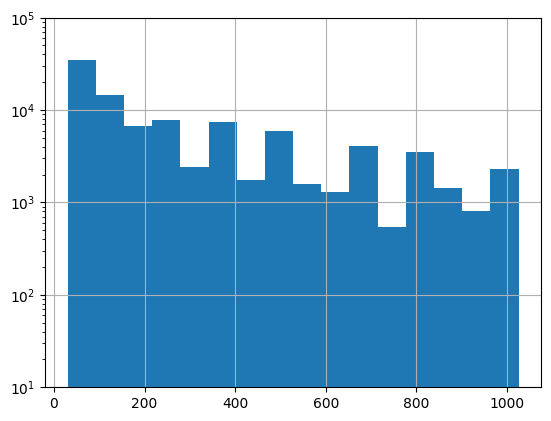

In [69]:
plt.hist( x  , bins = 16 )
plt.yscale( 'log' )
plt.grid()
plt.yticks( [10**i for i in range(1,6)])
plt.show()

In [72]:
torch.sum( x < 200 )*100/x.shape[0]

tensor(57.5198)

In [ ]:
positive_pair_indices = get_track_index_pairs(particle_ids,device)

In [ ]:
positive_pair_indices.shape 

torch.Size([2, 566181])

Wite a complete function to process a event. 

In [ ]:
def process_event_data(train_path:str,eventid:str,detector:dict,return_dataframe:bool=False): 
    '''
    train_path : path to the folder containing the csv files of the 
        evenid to process. 
    eventid : string containg the unique eventid. 
    return_dataframe : if true then return a Pandas Dataframe object, otherwise 
        return as pytorch tensor of the featuers excluding the hit id. 
    '''
    
    hits = pd.read_csv(train_path+eventid+'-hits.csv')
    cells = pd.read_csv(train_path+eventid+'-cells.csv')

    # initialize the processed event dataframe : 
    processed_event = hits.loc[: , ['hit_id' ]]
    # global spatial position of the hits :
    (
        processed_event['r'], 
        processed_event['sphi'],
        processed_event['cphi'],
        processed_event['z']
    ) = Cartesian_to_Cylindrical(*hits.loc[ : , ['x' , 'y' , 'z']].to_numpy().T)
    # number of cells activated 
    processed_event['ncells'] = cells.groupby('hit_id').hit_id.count().values.copy() 
    # total signal value deposited 
    processed_event['tvalue'] = cells.groupby('hit_id').value.sum().values.copy()
    
    get_local_differential_volume(processed_event,hits,cells,detector)
    
    get_orentations(processed_event,hits,cells,detector)
    
    if return_dataframe : 
        return processed_event
    else  : 
        return Tensor( processed_event.iloc[: , 1: ].values )

In [ ]:
# check the function for the same event index : 
processed_event_check = process_event_data(train_path,eventid,detector,return_dataframe=True)
processed_event_check

,hit_id,r,sphi,cphi,z,ncells,tvalue,lu,lv,lw,ltheta,lsphi,lcphi,gtheta,gsphi,gcphi
0,1,101.424864,-0.129712,-0.991552,-1502.5,2,0.330046,0.05,0.11250,0.3,0.389413,0.913812,0.406138,2.752180,-0.476583,-0.879129
1,2,68.688773,-0.100573,-0.994930,-1502.5,1,0.286314,0.05,0.05625,0.3,0.245794,0.747409,0.664364,2.895799,-0.720957,-0.692980
2,3,73.172847,-0.083567,-0.996502,-1502.5,1,0.237836,0.05,0.05625,0.3,0.245794,0.747409,0.664364,2.895799,-0.720957,-0.692980
3,4,58.757139,-0.028483,-0.999594,-1502.5,7,0.408580,0.20,0.22500,0.3,0.787128,0.747409,0.664364,2.354465,-0.720957,-0.692980
4,5,100.007771,-0.010743,-0.999942,-1502.5,1,0.287705,0.05,0.05625,0.3,0.245794,0.747409,0.664364,2.895799,-0.720957,-0.692980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115615,115616,984.116272,0.095068,-0.995471,2952.5,1,1.000000,0.12,10.40000,0.7,1.503594,0.999933,0.011538,1.503594,0.074301,-0.997236
115616,115617,952.874094,0.094244,-0.995549,2952.5,1,1.000000,0.12,10.40000,0.7,1.503594,0.999933,0.011538,1.503594,0.074301,-0.997236
115617,115618,994.083128,0.049894,-0.998755,2952.5,2,2.000000,0.24,10.40000,0.7,1.503608,0.999734,0.023071,1.503608,0.085799,-0.996312
115618,115619,890.010948,0.067634,-0.997710,2952.5,2,2.000000,0.24,10.40000,0.7,1.503608,0.999734,0.023071,1.503608,0.085799,-0.996312


In [ ]:
(processed_event_check != processed_event).sum().sum()

np.int64(0)